# Part 1: Data Collection & Cleaning

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Statement-&amp;-Methodology" data-toc-modified-id="Problem-Statement-&amp;-Methodology-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Statement &amp; Methodology</a></span></li><li><span><a href="#Importing-Libraries" data-toc-modified-id="Importing-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Libraries</a></span></li><li><span><a href="#Data-Collection" data-toc-modified-id="Data-Collection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Collection</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Word-Cloud" data-toc-modified-id="Word-Cloud-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Word Cloud</a></span></li></ul></div>

## Problem Statement & Methodology

Expressing oneself on online media (such as Facebook, Twitter, and YouTube) is not so easy. It often comes with the threat of abuse and harassment. This may result in people stopping to express themselves or seeking alternative platforms to express their opinions. Similarly, online chat platforms struggle to facilitate conversations which result in completely removing user comments. Thus, a tool which can help improve online conversations is indispensable given the increasingly high number of people on online platforms. 

In this project, we perform topic modeling to find out different types of toxicity involved in the corpus. Furthermore, using the topics' weight matrix, number of words in each text, and clustering info. as features, we classify the texts into toxic and non-toxic categories.

## Importing Libraries

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import os
import copy
import pickle 
import time
import gensim
import operator
import string 
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize, sent_tokenize, word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs
from itertools import cycle
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn import svm
from gensim import corpora, models, similarities, matutils
from mpl_toolkits import mplot3d
import gensim.downloader as api
import svdRec
import spacy
from functools import reduce
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.decomposition import LatentDirichletAllocation as LDA
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim import corpora
from nltk.corpus import stopwords
nltk.download('stopwords')
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()
from gensim.models import LdaModel
from nltk import word_tokenize, pos_tag
from gensim.models import CoherenceModel
import pyLDAvis.sklearn
import matplotlib.colors as mcolors
from collections import Counter
nltk.download('averaged_perceptron_tagger')
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
sys.setrecursionlimit(2*10**6) 

import warnings
warnings.filterwarnings('ignore');

[nltk_data] Downloading package punkt to /Users/chaudhary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chaudhary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chaudhary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chaudhary/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Data Collection

__Kaggle Dataset__

We obtained the dataset from Kaggle competition (https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview) which contains a large number of Wikipedia comments.

__Loading Kaggle Dataset:__

In [291]:
# Reading Kaggle Dataset
kaggle_data = pd.read_csv('../train.csv')

In [292]:
# Displaying first 5 comments
kaggle_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


__Dataset w/ Toxic Comments Only:__

Dataset with toxic comments is useful for topic modeling. This way we can identify some popular toxic topics under discussion. From the list of all possible comments, we select the one which includes one of the forms of toxicity as shown above in the dataframe.

In [293]:
kaggle_toxic_comments_list = []

for i in range(len(kaggle_data['comment_text'])):
    if (kaggle_data['toxic'][i] == 1) or (kaggle_data['severe_toxic'][i] == 1) or (kaggle_data['obscene'][i] == 1) or (kaggle_data['threat'][i] == 1) or (kaggle_data['insult'][i] == 1) or (kaggle_data['identity_hate'][i] == 1):
        kaggle_toxic_comments_list.append(kaggle_data['comment_text'][i])

In [294]:
kaggle_toxic_comments_list = pd.DataFrame(kaggle_toxic_comments_list, columns=["toxic_comments"]) 
kaggle_toxic_comments_list.head()

,toxic_comments
0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
1,Hey... what is it..\n@ | talk .\nWhat is it......
2,"Bye! \n\nDon't look, come or think of comming ..."
3,You are gay or antisemmitian? \n\nArchangel WH...
4,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!"


As observed in the above dataframe, we need to do quite a bit of data cleaning in order to perform topic modeling. For this, we would need to lowercase all the words, remove any alphanumerics, remove words shorter than length 3 (usually don't mean much in terms of topic modeling), and so on. Since we plan to do the binary text classification (classifying if a comment is toxic or not (Part 3)), we will clean both the toxic comments and the complete list of comments.

## Data Preprocessing

__Removing Alphanumerics & Punctuations and Lowercase Conversion:__

In [295]:
"""
"data_preprocessing" function: Removes any alphanumerics and punctuations. Additionally, it lowercases the input text.
"""
def data_preprocessing(data):
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    
    return data.map(alphanumeric).map(punc_lower)

In [296]:
# Toxic comments only
kaggle_toxic_comments = data_preprocessing(kaggle_toxic_comments_list["toxic_comments"])

In [297]:
kaggle_toxic_comments[:5]

0         cocksucker before you piss around on my work
1    hey    what is it  \n    talk  \nwhat is it   ...
2    bye  \n\ndon t look  come or think of comming ...
3    you are gay or antisemmitian  \n\narchangel wh...
4             fuck your filthy mother in the ass  dry 
Name: toxic_comments, dtype: object

In [298]:
# Complete list of comments
kaggle_comments_complete_list = data_preprocessing(kaggle_data["comment_text"])

__Removing Words Shorter Than Length 3:__

In [299]:
"""
"data_removingshortwords" function: Removes any words shorter than length 3 in a given input text.
"""
def data_removingshortwords(data):
    short_words = lambda x: re.sub(r'\b\w{1,2}\b', '', x)
    
    return data.map(short_words)

In [300]:
# Toxic comments only
kaggle_toxic_comments = data_removingshortwords(kaggle_toxic_comments)

In [301]:
kaggle_toxic_comments[:5]

0             cocksucker before you piss around   work
1    hey    what    \n    talk  \nwhat       exclus...
2    bye  \n\ndon  look  come  think  comming back ...
3    you are gay  antisemmitian  \n\narchangel whit...
4               fuck your filthy mother  the ass  dry 
Name: toxic_comments, dtype: object

In [303]:
# Complete list of comments
kaggle_comments_complete_list = data_removingshortwords(kaggle_comments_complete_list)

__Removing Any Linebreaks:__

In [304]:
"""
"remove_linebreaks" function: Removes any linebreaks in the text.
"""
def remove_linebreaks(data):
    kaggle_comments_linebreaks_removed = []
    for i in range(len(data)):
        data[i] = data[i].replace('\n',' ')
        kaggle_comments_linebreaks_removed.append(data[i])
    return kaggle_comments_linebreaks_removed

In [306]:
# Toxic comments only
kaggle_toxic_comments = remove_linebreaks(kaggle_toxic_comments)

In [307]:
kaggle_toxic_comments[:5]

['cocksucker before you piss around   work',
 'hey    what         talk   what       exclusive group  some  talibans   who are good  destroying  self appointed purist who gang  any one who asks them questions abt their anti social and destructive  non  contribution     ask sityush  clean  his behavior than issue  nonsensical warnings   ',
 'bye    don  look  come  think  comming back  tosser ',
 'you are gay  antisemmitian    archangel white tiger  meow  greetingshhh     there are two ways  why you  erased  comment about    that holocaust was brutally slaying  jews and not gays gypsys slavs anyone          you are anti semitian  than shave your head bald and   the skinhead meetings        you doubt words  the bible  that homosexuality   deadly sin  make  pentagram tatoo  your forehead   the satanistic masses with your gay pals       first and last warning  you fucking gay    won  appreciate  any more nazi shwain would write   page   don  wish  talk  you anymore   beware  the dark side 

In [308]:
# Complete list of comments
kaggle_comments_complete_list = remove_linebreaks(kaggle_comments_complete_list)

__Removing Any Whitespaces:__

In [309]:
"""
"remove_whitespace" function: Removes white space.
"""
def remove_whitespace(data):
    kaggle_comments_whitespace_removed = []
    for i in range(len(data)):
        data[i] = data[i].strip()
        kaggle_comments_whitespace_removed.append(data[i])
    return kaggle_comments_whitespace_removed

In [310]:
# Toxic comments only
kaggle_toxic_comments = remove_whitespace(kaggle_toxic_comments)

In [311]:
kaggle_toxic_comments[:5]

['cocksucker before you piss around   work',
 'hey    what         talk   what       exclusive group  some  talibans   who are good  destroying  self appointed purist who gang  any one who asks them questions abt their anti social and destructive  non  contribution     ask sityush  clean  his behavior than issue  nonsensical warnings',
 'bye    don  look  come  think  comming back  tosser',
 'you are gay  antisemmitian    archangel white tiger  meow  greetingshhh     there are two ways  why you  erased  comment about    that holocaust was brutally slaying  jews and not gays gypsys slavs anyone          you are anti semitian  than shave your head bald and   the skinhead meetings        you doubt words  the bible  that homosexuality   deadly sin  make  pentagram tatoo  your forehead   the satanistic masses with your gay pals       first and last warning  you fucking gay    won  appreciate  any more nazi shwain would write   page   don  wish  talk  you anymore   beware  the dark side',
 '

In [312]:
# Complete list of comments
kaggle_comments_complete_list = remove_whitespace(kaggle_comments_complete_list)

__Removing Any Duplicated Space:__

In [313]:
"""
"remove_duplicatedspace" function: Removes any duplicated white space.
"""
def remove_duplicatedspace(data):
    kaggle_comments_duplicatedspace_removed = []
    for i in range(len(data)):
        data[i] = " ".join(data[i].split())
        kaggle_comments_duplicatedspace_removed.append(data[i])
    return kaggle_comments_duplicatedspace_removed

In [314]:
# Toxic comments only
kaggle_toxic_comments = remove_duplicatedspace(kaggle_toxic_comments)

In [315]:
kaggle_toxic_comments[:5]

['cocksucker before you piss around work',
 'hey what talk what exclusive group some talibans who are good destroying self appointed purist who gang any one who asks them questions abt their anti social and destructive non contribution ask sityush clean his behavior than issue nonsensical warnings',
 'bye don look come think comming back tosser',
 'you are gay antisemmitian archangel white tiger meow greetingshhh there are two ways why you erased comment about that holocaust was brutally slaying jews and not gays gypsys slavs anyone you are anti semitian than shave your head bald and the skinhead meetings you doubt words the bible that homosexuality deadly sin make pentagram tatoo your forehead the satanistic masses with your gay pals first and last warning you fucking gay won appreciate any more nazi shwain would write page don wish talk you anymore beware the dark side',
 'fuck your filthy mother the ass dry']

In [316]:
# Complete list of comments
kaggle_comments_complete_list = remove_duplicatedspace(kaggle_comments_complete_list)

__Lemmatizing Tokens:__

In [317]:
"""
"lemmatizing" function: Lemmatizes the input text or it converts it to its base form. 
"""
def lemmatizing(data):
    nlp = spacy.load('en_core_web_sm')
    cleaned_text = []
    for i in range(len(data)):
        doc = nlp(data[i])
        cleaned_text.append(" ".join([token.lemma_ for token in doc]))

    return cleaned_text

In [318]:
# Toxic comments only
kaggle_toxic_comments_lemmatized = lemmatizing(kaggle_toxic_comments)

In [319]:
kaggle_toxic_comments_lemmatized[:5]

['cocksucker before -PRON- piss around work',
 'hey what talk what exclusive group some taliban who be good destroy self appoint purist who gang any one who ask -PRON- question abt -PRON- anti social and destructive non contribution ask sityush clean -PRON- behavior than issue nonsensical warning',
 'bye don look come think comme back tosser',
 '-PRON- be gay antisemmitian archangel white tiger meow greetingshhh there be two way why -PRON- erase comment about that holocaust be brutally slay jew and not gay gypsys slavs anyone -PRON- be anti semitian than shave -PRON- head bald and the skinhead meeting -PRON- doubt word the bible that homosexuality deadly sin make pentagram tatoo -PRON- forehead the satanistic masse with -PRON- gay pal first and last warning -PRON- fucking gay won appreciate any more nazi shwain would write page don wish talk -PRON- anymore beware the dark side',
 'fuck -PRON- filthy mother the ass dry']

In [320]:
# Complete list of comments
kaggle_comments_complete_list_lemmatized = lemmatizing(kaggle_comments_complete_list)

__Removing "-PRON-" Generated By Spacy Lemmatization:__

In [321]:
"""
"remove_pron" function: Removes "-PRON-" generated by lemmatized pronouns when using spacy lemmatization.
"""
def remove_pron(data):
    kaggle_comments_pron_removed = []
    for i in range(len(data)):
        data[i] = data[i].replace('-PRON-','')
        kaggle_comments_pron_removed.append(data[i])
    return kaggle_comments_pron_removed

In [322]:
# Toxic comments only
kaggle_toxic_comments_lemmatized = remove_pron(kaggle_toxic_comments_lemmatized)

In [327]:
kaggle_toxic_comments_lemmatized[:5]

['cocksucker before  piss around work',
 'hey what talk what exclusive group some taliban who be good destroy self appoint purist who gang any one who ask  question abt  anti social and destructive non contribution ask sityush clean  behavior than issue nonsensical warning',
 'bye don look come think comme back tosser',
 ' be gay antisemmitian archangel white tiger meow greetingshhh there be two way why  erase comment about that holocaust be brutally slay jew and not gay gypsys slavs anyone  be anti semitian than shave  head bald and the skinhead meeting  doubt word the bible that homosexuality deadly sin make pentagram tatoo  forehead the satanistic masse with  gay pal first and last warning  fucking gay won appreciate any more nazi shwain would write page don wish talk  anymore beware the dark side',
 'fuck  filthy mother the ass dry']

In [328]:
# Complete list of comments
kaggle_comments_complete_list_lemmatized = remove_pron(kaggle_comments_complete_list_lemmatized)

__Further Removal of Short Words After Lemmatization:__

In [329]:
# Toxic comments only
kaggle_toxic_comments_lemmatized_df = pd.DataFrame(kaggle_toxic_comments_lemmatized,columns=['toxic_comments'])

In [330]:
# Toxic comments only
kaggle_toxic_comments_lemmatized = data_removingshortwords(kaggle_toxic_comments_lemmatized_df['toxic_comments'])

In [331]:
kaggle_toxic_comments_lemmatized[:5]

0                  cocksucker before  piss around work
1    hey what talk what exclusive group some taliba...
2            bye don look come think comme back tosser
3      gay antisemmitian archangel white tiger meow...
4                      fuck  filthy mother the ass dry
Name: toxic_comments, dtype: object

In [332]:
# Complete list of comments
kaggle_comments_complete_list_lemmatized_df = pd.DataFrame(kaggle_comments_complete_list_lemmatized,columns=['comments'])


In [333]:
# Complete list of comments
kaggle_comments_complete_list_lemmatized = data_removingshortwords(kaggle_comments_complete_list_lemmatized_df['comments'])

__Further Removal of White Space:__

Now, there are additional white spaces due to removal of words shorter than length 3. Thus, we remove those as shown below.

In [334]:
# Toxic comments only
kaggle_toxic_comments_lemmatized = remove_duplicatedspace(kaggle_toxic_comments_lemmatized)

In [335]:
kaggle_toxic_comments_lemmatized[:5]

['cocksucker before piss around work',
 'hey what talk what exclusive group some taliban who good destroy self appoint purist who gang any one who ask question abt anti social and destructive non contribution ask sityush clean behavior than issue nonsensical warning',
 'bye don look come think comme back tosser',
 'gay antisemmitian archangel white tiger meow greetingshhh there two way why erase comment about that holocaust brutally slay jew and not gay gypsys slavs anyone anti semitian than shave head bald and the skinhead meeting doubt word the bible that homosexuality deadly sin make pentagram tatoo forehead the satanistic masse with gay pal first and last warning fucking gay won appreciate any more nazi shwain would write page don wish talk anymore beware the dark side',
 'fuck filthy mother the ass dry']

In [336]:
# Complete list of comments
kaggle_comments_complete_list_lemmatized = remove_duplicatedspace(kaggle_comments_complete_list_lemmatized)

After lemmatization, we extract only nouns and adjectives from the corpus. In general, nouns and adjectives are much more representative of topic under discussion in different comments/texts.

__Collecting Only Nouns and Adjectives From Corpus:__

In [337]:
"""
Given a text, the following function tokenizes the text and pulls out only the nouns and adjectives.
"""
def nouns_adj(data):    
    kaggle_comments_nouns_adj = []
    for i in range(len(data)):
        is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
        tokenized = word_tokenize(data[i])
        nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
        kaggle_comments_nouns_adj.append(' '.join(nouns_adj))
    return kaggle_comments_nouns_adj

In [338]:
# Toxic comments only
kaggle_toxic_comments_lemmatized_nouns_adj = nouns_adj(kaggle_toxic_comments_lemmatized)

In [339]:
# Complete list of comments
kaggle_comments_complete_lemmatized_nouns_adj = nouns_adj(kaggle_comments_complete_list_lemmatized)

__Saving Lemmatized Corpora as csv Files:__

In [340]:
kaggle_toxic_comments_lemmatized_nouns_adj_df = pd.DataFrame(kaggle_toxic_comments_lemmatized_nouns_adj,columns = ["toxic_comments"])

In [341]:
kaggle_toxic_comments_lemmatized_nouns_adj_df.to_csv(r'../kaggle_toxic_comments_lemmatized_nouns_adj.csv')


In [342]:
kaggle_comments_complete_lemmatized_nouns_adj_df = pd.DataFrame(kaggle_comments_complete_lemmatized_nouns_adj,columns = ["comments"])

In [343]:
kaggle_comments_complete_lemmatized_nouns_adj_df.to_csv(r'../kaggle_comments_complete_lemmatized_nouns_adj.csv')

## Word Cloud

Word cloud shows the prominent words or the ones that appear frequently in the corpus.

In [344]:
"""
"word_cloud" function: Displays image with frequent words in the corpus.
"""

def word_cloud(data):
    kaggle_string = ','.join(list(data.values))
    wordcloud = WordCloud(collocations=False,background_color = "white", max_words = 5000, contour_width = 3, contour_color = 'steelblue')
    wordcloud.generate(kaggle_string)
    return wordcloud.to_image()
# plt.savefig('wordcloud.png',dpi=600)

__Word Cloud Using Toxic Comments:__

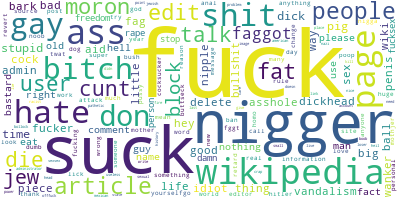

In [345]:
word_cloud(kaggle_toxic_comments_lemmatized_nouns_adj_df["toxic_comments"])

__Word Cloud Using All Comments:__

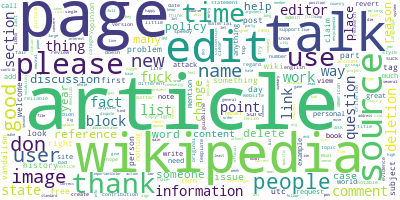

In [346]:
word_cloud(kaggle_comments_complete_lemmatized_nouns_adj_df["comments"])

__Note: Part 2 Discusses Topic Modeling On Toxic Comments__